In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from scipy import stats
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


In [2]:
# print(os.getcwd())
# os.chdir('../../')
# print(os.getcwd())

In [3]:
# base_input_dir = "inputs/train/"
# base_output_dir = "outputs/"

# base_test_score_path = "outputs/test_scores/"


In [4]:
base_input_dir = "/data/tasnina/drug-synergy-prediction/inputs/train/"
base_output_dir = "/data/tasnina/drug-synergy-prediction/outputs/"

base_test_score_path = "/data/tasnina/drug-synergy-prediction/outputs/test_scores/"

In [5]:
feature_types = ['MACCS_Target','only_MACCS']
model = 'GBR'

In [6]:
#cell lines having more than 2000 drugpairs in it 
list_of_cell_lines = ['NCI-H226', 'HCC-2998', 'MDA-MB-435', 
 'DIPG25', 'COLO 205', 'HCT-15', 'HOP-92', 'TK-10', 'U251', 'HL-60(TB)', 'CCRF-CEM', 'EKVX', 
 'NCI-H522', 'SW-620','MALME-3M', 'RPMI-8226','NCI-H322M','UO-31','MDA-MB-231', 'SK-MEL-5','HS 578T',
 'M14', 'T-47D', 'SR', 'SF-539', 'OVCAR-8','OVCAR-5', 'SK-OV-3', 'OVCAR-4', 'TMD8',
 'HOP-62', 'NCIH23', 'IGROV1', 'ACHN', 'MCF7','SNB-19', '786-0', 'MDA-MB-468', 'K-562', 'SF-268', 'KBM-7', 
 'KM12', 'SF-295','A498', 'HCT116', 'OVCAR3', 'CAKI-1', 'BT-549', 'UACC62', 
 'A549','NCI-H460','SN12C', 'MOLT-4', 'SNB-75', 'HT29', 'RXF 393', 'LOX IMVI', 'UACC-257', 'SK-MEL-28', 'DU-145']


In [7]:
def pearson_correlation_func(y_true, y_pred):
    pearsons_r, p_value = stats.pearsonr(y_true, y_pred)
    return pearsons_r

In [8]:
def plot_score(score_dict, score_type, loss_function, cell_line, output_dir):
    # plot the score_type(e.g. mse, r2, pearsons correlation)
    x = list(score_dict.keys())
    y = list(score_dict.values())
    plt.plot(x, y)
    plt.xlabel('max_depth')
    plt.ylabel(score_type)
    
    title = score_type + ' vs max_depth for '+ loss_function + 'loss in '+ cell_line 
    plt.title(title)
    
    file_name = output_dir + cell_line + '/' +  loss_function + '_' + score_type + '_plot.pdf'
    
    plt.savefig(file_name, bbox_inches ="tight", format = 'pdf')
    print(file_name, ' saved')
    
    plt.show()
    plt.close()

In [9]:
def GBR_model(input_dir,output_dir,list_of_cell_lines ):

    scoring = {'r2': make_scorer(r2_score),'mean_squared_error':make_scorer(mean_squared_error), \
               'pearsons_correlation_score':make_scorer(pearson_correlation_func)}

    for cell_line in list_of_cell_lines:
        print(cell_line)
        feature_file = input_dir+cell_line+'_features.tsv'
        label_file = input_dir+cell_line+'_labels.tsv'

        feature = pd.read_csv(feature_file,sep='\t').to_numpy()
        # print(feature, feature.shape)
        label = pd.read_csv(label_file,sep='\t')['Loewe'].to_numpy()
        # print(label, label.shape)

        X_train, X_test, y_train, y_test = train_test_split(
            feature, label, test_size=0.1, random_state=0)

        loss_function = 'ls'
        file_name = output_dir + cell_line + '/' +  loss_function + '_r2_mse_pearsons_score.tsv'
     
        if(not os.path.exists(file_name)):
            os.makedirs(os.path.dirname(file_name), exist_ok=True)

            avg_r2_dict = {}
            avg_mse_dict = {}
            avg_pearsons_dict ={}
            for max_depth in range(1,6,1):
                gb_reg_model = GradientBoostingRegressor(random_state=0, loss= loss_function, max_depth=max_depth)
                scores = cross_validate(gb_reg_model, X_train,y_train, cv=5, \
                                                    scoring = scoring)
                avg_r2 = np.average(scores['test_r2'])
                avg_mse =  np.average(scores['test_mean_squared_error'])
                avg_pearsons_corr = np.average(scores['test_pearsons_correlation_score'])

                print('r2 ', avg_r2)
                print('mse ', avg_mse)
                print('pearsons correlation ', avg_pearsons_corr)


                avg_r2_dict[max_depth] = avg_r2
                avg_mse_dict[max_depth] = avg_mse
                avg_pearsons_dict[max_depth] = avg_pearsons_corr

            #save these dictionary values as a df in file
            r2_mse_pearson_score_df = pd.concat([pd.Series(avg_r2_dict,name='r2'), \
                                          pd.Series(avg_mse_dict,name = 'mse'),\
                                          pd.Series(avg_pearsons_dict,name='pearsons')],axis=1)

    #         r2_rmse_pearson_score_df = pd.DataFrame(pd.Series(avg_pearsons_dict,name='pearsons'))

            r2_mse_pearson_score_df.to_csv(file_name, sep='\t')

        else:
            print(file_name + ' already exists')

        r2_mse_pearson_score_df = pd.read_csv(file_name, sep='\t', index_col = 'Unnamed: 0')

        avg_r2_dict = r2_mse_pearson_score_df['r2'].to_dict()
        avg_mse_dict = r2_mse_pearson_score_df['mse'].to_dict()
        avg_pearsons_dict = r2_mse_pearson_score_df['pearsons'].to_dict()

        # plot and save mse, r2 , pearsons scores
        plot_score(avg_r2_dict, 'r2', loss_function, cell_line,output_dir)
        plot_score(avg_mse_dict,'mse', loss_function, cell_line,output_dir)
        plot_score(avg_pearsons_dict,'pearsons', loss_function, cell_line,output_dir)



inputs/train//MACCS_Target/ outputs//MACCS_Target/GBR/
NCI-H226
outputs//MACCS_Target/GBR/NCI-H226/ls_r2_mse_pearsons_score.tsv already exists
outputs//MACCS_Target/GBR/NCI-H226/ls_r2_plot.pdf  saved


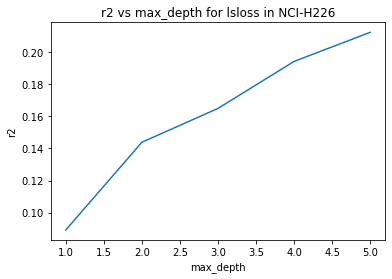

outputs//MACCS_Target/GBR/NCI-H226/ls_mse_plot.pdf  saved


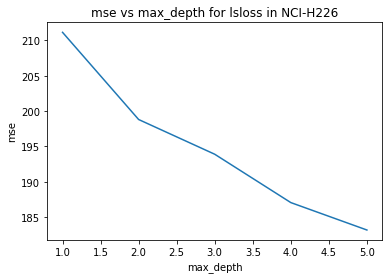

outputs//MACCS_Target/GBR/NCI-H226/ls_pearsons_plot.pdf  saved


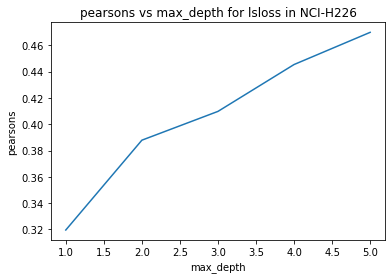

HCC-2998
outputs//MACCS_Target/GBR/HCC-2998/ls_r2_mse_pearsons_score.tsv already exists
outputs//MACCS_Target/GBR/HCC-2998/ls_r2_plot.pdf  saved


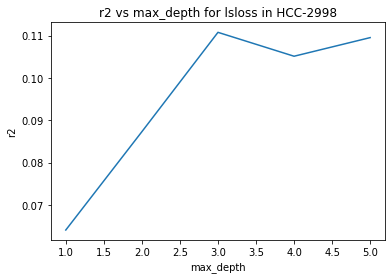

outputs//MACCS_Target/GBR/HCC-2998/ls_mse_plot.pdf  saved


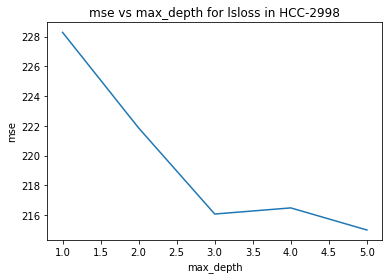

outputs//MACCS_Target/GBR/HCC-2998/ls_pearsons_plot.pdf  saved


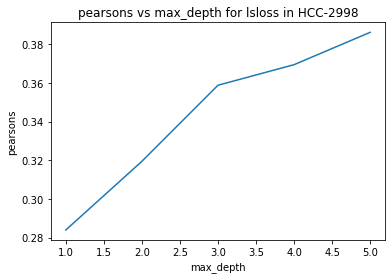

MDA-MB-435
outputs//MACCS_Target/GBR/MDA-MB-435/ls_r2_mse_pearsons_score.tsv already exists
outputs//MACCS_Target/GBR/MDA-MB-435/ls_r2_plot.pdf  saved


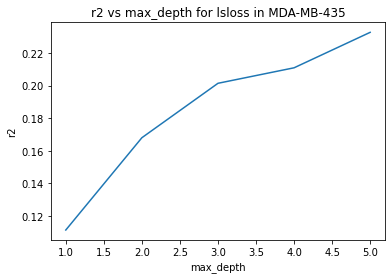

outputs//MACCS_Target/GBR/MDA-MB-435/ls_mse_plot.pdf  saved


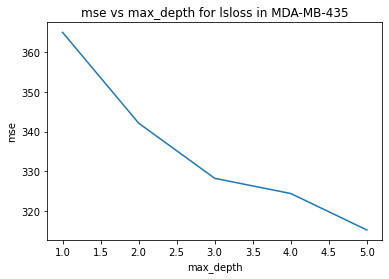

outputs//MACCS_Target/GBR/MDA-MB-435/ls_pearsons_plot.pdf  saved


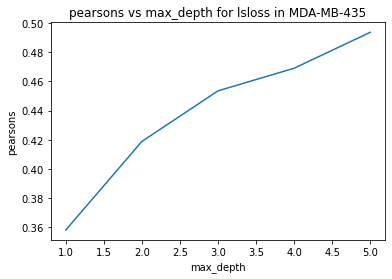

DIPG25
outputs//MACCS_Target/GBR/DIPG25/ls_r2_mse_pearsons_score.tsv already exists
outputs//MACCS_Target/GBR/DIPG25/ls_r2_plot.pdf  saved


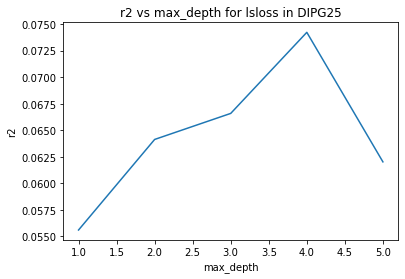

outputs//MACCS_Target/GBR/DIPG25/ls_mse_plot.pdf  saved


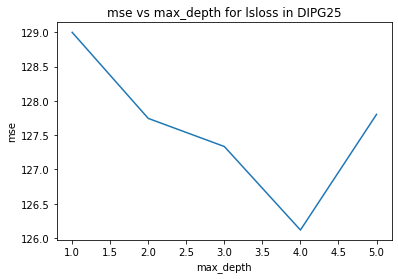

outputs//MACCS_Target/GBR/DIPG25/ls_pearsons_plot.pdf  saved


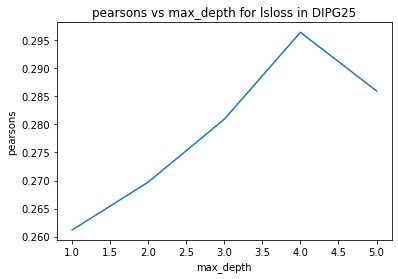

COLO 205
outputs//MACCS_Target/GBR/COLO 205/ls_r2_mse_pearsons_score.tsv already exists
outputs//MACCS_Target/GBR/COLO 205/ls_r2_plot.pdf  saved


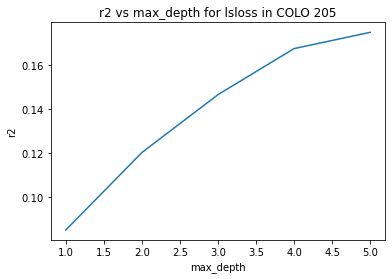

outputs//MACCS_Target/GBR/COLO 205/ls_mse_plot.pdf  saved


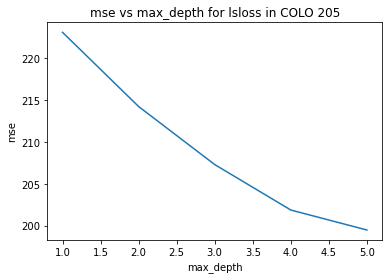

outputs//MACCS_Target/GBR/COLO 205/ls_pearsons_plot.pdf  saved


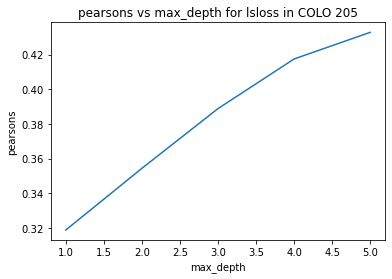

HCT-15
outputs//MACCS_Target/GBR/HCT-15/ls_r2_mse_pearsons_score.tsv already exists


KeyboardInterrupt: 

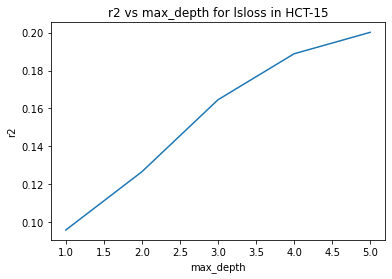

In [9]:
for feature_combo in feature_types:
    input_dir = base_input_dir + '/' + feature_combo + '/'
    output_dir = base_output_dir + '/' + feature_combo + '/' + model +'/'
    
    print(input_dir, output_dir)
    GBR_model(input_dir ,output_dir, list_of_cell_lines )

In [10]:
def find_best_max_depth(file_name,metric):
    ## Here, metric is such that the lowest value => best model
    ## this function will output the value max_depth for which the chosen metric (i.e. mse)is the lowest.  
    score_df = pd.read_csv(file_name, sep='\t', index_col = 'Unnamed: 0')

    avg_metric_dict = score_df[metric].to_dict()
    
    index_with_min_value_for_metric = min(avg_metric_dict, key=avg_metric_dict.get)
    
    min_metric_val =avg_metric_dict[index_with_min_value_for_metric]
        
    return index_with_min_value_for_metric,  min_metric_val

In [11]:
def compute_test_score_GBR(input_dir, max_depth):
    # compute performance on the test dataset.
    feature_file = input_dir+cell_line+'_features.tsv'
    label_file = input_dir+cell_line+'_labels.tsv'

    feature = pd.read_csv(feature_file,sep='\t').to_numpy()
    label = pd.read_csv(label_file,sep='\t')['Loewe'].to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(
        feature, label, test_size=0.1, random_state=0)
    loss_function = 'ls'
    gb_reg_model = GradientBoostingRegressor(random_state=0, loss= loss_function, max_depth=max_depth).\
                   fit(X_train, y_train)
    
    y_pred = gb_reg_model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred, squared=True)
    r2 = r2_score(y_test, y_pred)
    pearsons = pearson_correlation_func(y_test, y_pred)
    
    return r2, mse, pearsons

In [12]:
#for each cell line find out the best hyperparameter and train model using those. Then compute performance on the
#test dataset.

for feature_combo in feature_types:
    input_dir = base_input_dir + '/' + feature_combo + '/'
    output_dir = base_output_dir + '/' + feature_combo + '/' + model +'/'
    
    test_score_file =  base_test_score_path + '/' + model + '_'+ feature_combo+'_test_score.tsv'
    all_cell_line_test_score_df= {}
    
    for cell_line in list_of_cell_lines:
        file_name = output_dir+ cell_line + '/ls_r2_mse_pearsons_score.tsv'
        max_depth, min_mse = find_best_max_depth(file_name,'mse')
        r2 , mse, pearsons =  compute_test_score_GBR (input_dir,max_depth)
        all_cell_line_test_score_df[cell_line] = {'max_depth':  max_depth, 'min_5_fold_mse':min_mse,\
                                                  'r2' : r2, 'mse' : mse, 'pearsons' : pearsons}
        print(cell_line,  all_cell_line_test_score_df[cell_line])
    df = pd.DataFrame.from_dict(all_cell_line_test_score_df, orient='index')  
    
    os.makedirs(os.path.dirname(test_score_file), exist_ok=True)
    df.to_csv(test_score_file, sep = '\t')

NCI-H226 {'max_depth': 5, 'min_5_fold_mse': 183.17827953092444, 'r2': 0.19037152557117631, 'mse': 144.06425868832298, 'pearsons': 0.4487458244683808}
HCC-2998 {'max_depth': 5, 'min_5_fold_mse': 214.9941894563109, 'r2': 0.11060103777070407, 'mse': 178.0348236741168, 'pearsons': 0.37384632251316363}
MDA-MB-435 {'max_depth': 5, 'min_5_fold_mse': 315.2308718452879, 'r2': 0.19754776031744803, 'mse': 416.056411401024, 'pearsons': 0.45372604667049027}
DIPG25 {'max_depth': 4, 'min_5_fold_mse': 126.11801302352305, 'r2': 0.09396196593507733, 'mse': 139.439465064496, 'pearsons': 0.31465796418068065}
COLO 205 {'max_depth': 5, 'min_5_fold_mse': 199.48376305975438, 'r2': 0.21305305026061405, 'mse': 177.58295784892647, 'pearsons': 0.4662475105791517}
HCT-15 {'max_depth': 5, 'min_5_fold_mse': 206.64007418902537, 'r2': 0.26526698225224876, 'mse': 183.08577993404046, 'pearsons': 0.5176524146301055}
HOP-92 {'max_depth': 5, 'min_5_fold_mse': 169.7418674058743, 'r2': 0.2099678623119946, 'mse': 200.12535557

LOX IMVI {'max_depth': 5, 'min_5_fold_mse': 167.00219871954582, 'r2': 0.23482766180848946, 'mse': 181.05074328765437, 'pearsons': 0.48731399759639105}
UACC-257 {'max_depth': 5, 'min_5_fold_mse': 172.6847497396123, 'r2': 0.35500219289767443, 'mse': 178.6153289388798, 'pearsons': 0.6007350573679713}
SK-MEL-28 {'max_depth': 4, 'min_5_fold_mse': 217.2534015206963, 'r2': 0.2850633713269489, 'mse': 165.05993792208454, 'pearsons': 0.5367330448580183}
DU-145 {'max_depth': 5, 'min_5_fold_mse': 213.7366116686846, 'r2': 0.39061245616543505, 'mse': 174.43176775773054, 'pearsons': 0.6359090950680673}
NCI-H226 {'max_depth': 5, 'min_5_fold_mse': 183.04643750170902, 'r2': 0.1895561893677078, 'mse': 144.20933857304087, 'pearsons': 0.4621869914038919}
HCC-2998 {'max_depth': 4, 'min_5_fold_mse': 211.4472603564124, 'r2': 0.16415136488637794, 'mse': 167.3154238877335, 'pearsons': 0.41643165705372676}
MDA-MB-435 {'max_depth': 5, 'min_5_fold_mse': 301.9008328192257, 'r2': 0.26359853311775305, 'mse': 381.8103

MOLT-4 {'max_depth': 5, 'min_5_fold_mse': 210.491751929485, 'r2': 0.22413826135597514, 'mse': 248.09799215132617, 'pearsons': 0.47669684420498243}
SNB-75 {'max_depth': 5, 'min_5_fold_mse': 199.62737012849968, 'r2': 0.4326956585135029, 'mse': 182.27683324985716, 'pearsons': 0.6743405282900832}
HT29 {'max_depth': 5, 'min_5_fold_mse': 220.7980885219237, 'r2': 0.2218370380496606, 'mse': 215.1333384605584, 'pearsons': 0.48308667846265113}
RXF 393 {'max_depth': 4, 'min_5_fold_mse': 152.23919339834498, 'r2': 0.09743928293839021, 'mse': 202.39950265416115, 'pearsons': 0.3437403846614046}
LOX IMVI {'max_depth': 5, 'min_5_fold_mse': 167.63090898961985, 'r2': 0.29315457957921476, 'mse': 167.24975847810592, 'pearsons': 0.5420560061913704}
UACC-257 {'max_depth': 5, 'min_5_fold_mse': 176.0176142402473, 'r2': 0.2676551892181531, 'mse': 202.80380465499667, 'pearsons': 0.526905243228316}
SK-MEL-28 {'max_depth': 4, 'min_5_fold_mse': 225.45722841800116, 'r2': 0.21427276475718338, 'mse': 181.4036146302697